In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def rk4_step(state, f, t, dt, *args):
    '''
    state: a tuple that include all nodes of each variable.
    f: the specific expression of the equation, the expression of the time derivative.
    dt: time step
    '''

    # k1
    k1 = f(state, t, *args)
    # add dt/2*k1 to each component of state
    state_k1 = tuple(s + 0.5 * dt * k for s, k in zip(state, k1))

    # k2
    k2 = f(state_k1, t + 0.5 * dt, *args)
    # add dt/2*k2 to each component of state
    state_k2 = tuple(s + 0.5 * dt * k for s, k in zip(state, k2))

    # k3
    k3 = f(state_k2, t + 0.5 * dt, *args)
    # add dt * k3 to each component of state
    state_k3 = tuple(s + dt* k for s, k in zip(state, k3))

    # k4
    k4 = f(state_k3, t + dt, *args)

    # update
    new_state = tuple(
        s + (dt/6.0) * (k1_i + 2*k2_i + 2*k3_i + k4_i)
        for s, k1_i, k2_i, k3_i, k4_i in zip(state, k1, k2, k3, k4)
    )

    return new_state

In [40]:
def square_rhombus_coupled_wave_equations(state, t, K, theta0, alpha, dx):
    # u, v, theta are the disp, w, z, phi are the velocity
    u11, w11, u21, w21, u12, w12, u22, w22, v11, z11, v21, z21, v12, z12, v22, z22, theta11, phi11, theta21, phi21, theta12, phi12, theta22, phi22 = state
    N = len(u11) - 1

    du11_dt = np.zeros_like(u11)
    dw11_dt = np.zeros_like(w11)
    du21_dt = np.zeros_like(u21)
    dw21_dt = np.zeros_like(w21)
    du12_dt = np.zeros_like(u12)
    dw12_dt = np.zeros_like(w12)
    du22_dt = np.zeros_like(u22)
    dw22_dt = np.zeros_like(w22)
    dv11_dt = np.zeros_like(v11)
    dz11_dt = np.zeros_like(z11)
    dv21_dt = np.zeros_like(v21)
    dz21_dt = np.zeros_like(z21)
    dv12_dt = np.zeros_like(v12)
    dz12_dt = np.zeros_like(z12)
    dv22_dt = np.zeros_like(v22)
    dz22_dt = np.zeros_like(z22)
    dtheta11_dt = np.zeros_like(theta11)
    dphi11_dt = np.zeros_like(phi11)
    dtheta21_dt = np.zeros_like(theta21)
    dphi21_dt = np.zeros_like(phi21)
    dtheta12_dt = np.zeros_like(theta12)
    dphi12_dt = np.zeros_like(phi12)
    dtheta22_dt = np.zeros_like(theta22)
    dphi22_dt = np.zeros_like(phi22)

    for i in range(1, N):

        # du11_dt[i] = w11[i]
        # dw11_dt[i] = (u12[i+1] - 2 * u12[i] + u12[i-1]) / dx**2 - 4 * u11[i] + 2 * u12[i] + u21[i] + K * theta11[i] * (theta12[i+1] - theta12[i-1]) / (2*dx) + (1 + K) * np.tan(theta0) * (theta12[i+1] - theta12[i-1]) / (2*dx) + 1 / 2 * theta21[i] * (1 - K + K * theta11[i] * np.tan(theta0))
        # du21_dt[i] = w21[i]
        # dw21_dt[i] = 1 / 2 * (2 * (u22[i+1] - 2 * u22[i] + u22[i-1]) / dx**2 + 2 * u11[i] - 6 * u21[i] + 4 * u22[i] + (1 + K) * theta11[i] - (1 + K + K * 2 * (theta22[i+1] - theta22[i-1]) / (2*dx)) * theta21[i] - (2 * (theta22[i+1] - theta22[i-1]) / (2*dx) * (-1 + K) + K * theta11[i] * theta21[i]) * np.tan(theta0))
        # dv11_dt[i] = z11[i]
        # dz11_dt[i] = (v12[i+1] - 2 * v12[i] + v12[i-1]) / dx**2 - 4 * v11[i] + 2 * v12[i] + v21[i] + 1 / 2 * theta21[i] * (K * theta11[i] + (1 + K) * np.tan(theta0)) + (theta12[i+1] - theta12[i-1]) / (2*dx) * (-1 + K - K * theta11[i] * np.tan(theta0))
        # dv21_dt[i] = z21[i]
        # dz21_dt[i] = (v22[i+1] - 2 * v22[i] + v22[i-1]) / dx**2 + (1 + K) * (theta22[i+1] - theta22[i-1]) / (2*dx) + v11[i] - 5 * v21[i] + 2 * v22[i] + K / 2 * theta11[i] * theta21[i] + 1 / 2 * ((-1 + K) * theta11[i] + theta21[i] - (1 + 2 * (theta22[i+1] - theta22[i+1]) / (2*dx)) * K * theta21[i]) * np.tan(theta0)
        # dtheta11_dt[i] = phi11[i]
        # dphi11_dt[i] = alpha**2 * (-4 * theta11[i] - 4 * K * theta11[i] - 2 * K * theta12[i] - K * theta21[i] + (2 * u21[i] - 2 * v21[i] * theta11[i]) * np.cos(theta0)**2 + (2 * theta12[i] + theta21[i]) * np.cos(2 * theta0)
        #                            + (u12[i+1] - u12[i-1]) / (2*dx) * (-4 * theta11[i] * np.cos(theta0)**2 - 2 * np.sin(2 * theta0)) + (-v21[i] - u21[i] * theta21[i] - 2 * theta11[i] * theta12[i] - theta11[i] * theta21[i]) * np.sin(2 * theta0)
        #                            + (theta12[i+1] - 2 * theta12[i] + theta12[i-1]) / (dx**2) * (-K + np.cos(2 * theta0) - theta11[i] * np.sin(2 * theta0)) + (v12[i+1] - v12[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2 + 2 * theta11[i] * np.sin(2 * theta0)))
        # dtheta21_dt[i] = phi21[i]
        # dphi21_dt[i] = alpha**2 * (-u11[i] + u21[i] + 4 * theta21[i] - v11[i] * theta21[i] - v21[i] * theta21[i] - K * (theta11[i] + 5 * theta21[i] + 2 * theta22[i]) 
        #                            + (-u11[i] + u21[i] - theta11[i] - theta21[i] - v11[i] * theta21[i] - v21[i] * theta21[i] - 2 * theta22[i]) * np.cos(2 * theta0) 
        #                            + (-v11[i] - v21[i] + u11[i] * theta21[i] - u21[i] * theta21[i] + theta11[i] * theta21[i] + 2 * theta21[i] * theta22[i]) * np.sin(2 * theta0)
        #                            + (u22[i+1] - u22[i-1]) / (2*dx) * (2 * theta21[i] + 2 * theta21[i] * np.cos(2 * theta0) + 2 * np.sin(2 * theta0))
        #                            + (theta22[i+1] - 2 * theta22[i] + theta22[i-1]) / (dx**2) * (-K - np.cos(2 * theta0) + theta21[i] * np.sin(2 * theta0))
        #                            + (v22[i+1] - v22[i-1]) / (2*dx) * (-2 - 2 * np.cos(2 * theta0) + 2 * theta21[i] * np.sin(2 * theta0)))
        # du12_dt[i] = w12[i]
        # dw12_dt[i] = (u11[i+1] - 2 * u11[i] + u11[i-1]) / dx**2 + 2 * u11[i] - 2 * u12[i] - (theta11[i+1] - theta11[i-1]) / (2*dx) * (K * theta12[i] + (-1 + K) * np.tan(theta0))
        # du22_dt[i] = w22[i]
        # dw22_dt[i] = (u21[i+1] - 2 * u21[i] + u21[i-1]) / dx**2 + 2 * u21[i] - 2 * u22[i] + (theta21[i+1] - theta21[i-1]) / (2*dx) * (K * theta22[i] + (1 + K) * np.tan(theta0))
        # dv12_dt[i] = z12[i]
        # dz12_dt[i] = (v11[i+1] - 2 * v11[i] + v11[i-1]) / dx**2 + (1 + K - K * theta12[i] * np.tan(theta0)) * (theta11[i+1] - theta11[i-1]) / (2*dx) + 2 * v11[i] - 2 * v12[i]
        # dv22_dt[i] = z22[i]
        # dz22_dt[i] = (v21[i+1] - 2 * v21[i] + v21[i-1]) / dx**2 + (-1 + K - K * theta22[i] * np.tan(theta0)) * (theta21[i+1] - theta21[i-1]) / (2*dx) + 2 * v21[i] - 2 * v22[i]
        # dtheta12_dt[i] = phi12[i]
        # dphi12_dt[i] = alpha**2 * (2 * theta12[i] - 2 * K * (theta11[i] + theta12[i]) - 2 * theta11[i] * np.cos(2 * theta0) + 2 * theta11[i] * theta12[i] * np.sin(2 * theta0)
        #                            + (u11[i+1] - u11[i-1]) / (2*dx) * (4 * theta12[i] * np.cos(theta0)**2 + 2 * np.sin(2 * theta0))
        #                            + (theta11[i+1] - 2 * theta11[i] + theta11[i-1]) / (dx**2) * (-K - np.cos(2 * theta0) + theta12[i] * np.sin(2 * theta0))
        #                            + (v11[i+1] - v11[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2 + 2 * theta12[i] * np.sin(2 * theta0)))
        # dtheta22_dt[i] = phi22[i]
        # dphi22_dt[i] = alpha**2 * (-2 * theta22[i] - 2 * K * (theta21[i] + theta22[i]) + 2 * theta21[i] * np.cos(2 * theta0) 
        #                            + (u21[i+1] - u21[i-1]) / (2*dx) * (-4 * theta22[i] * np.cos(theta0)**2 - 2 * np.sin(2 * theta0))
        #                            - 2 * theta21[i] * theta22[i] * np.sin(2 * theta0) + (theta21[i+1] - 2 * theta21[i] + theta21[i-1]) / (dx**2) * (-K + np.cos(2 * theta0) - theta22[i] * np.sin(2 * theta0))
        #                            + (v21[i+1] - v21[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2 + 2 * theta22[i] * np.sin(2 * theta0)))

        # du11_dt[i] = w11[i]
        # dw11_dt[i] = (u12[i+1] - 2 * u12[i] + u12[i-1]) / dx**2 - 4 * u11[i] + 2 * u12[i] + u21[i] + K * theta11[i] * (theta12[i+1] - theta12[i-1]) / (2*dx) + (1 + K) * np.tan(theta0) * (theta12[i+1] - theta12[i-1]) / (2*dx) + 1 / 2 * theta21[i] * (1 - K + K * theta11[i] * np.tan(theta0))
        # du21_dt[i] = w21[i]
        # dw21_dt[i] = 1 / 2 * (2 * (u22[i+1] - 2 * u22[i] + u22[i-1]) / dx**2 + 2 * u11[i] - 6 * u21[i] + 4 * u22[i] + (1 + K) * theta11[i] - (1 + K + K * 2 * (theta22[i+1] - theta22[i-1]) / (2*dx)) * theta21[i] - (2 * (theta22[i+1] - theta22[i-1]) / (2*dx) * (-1 + K) + K * theta11[i] * theta21[i]) * np.tan(theta0))
        # dv11_dt[i] = z11[i]
        # dz11_dt[i] = (v12[i+1] - 2 * v12[i] + v12[i-1]) / dx**2 - 4 * v11[i] + 2 * v12[i] + v21[i] + 1 / 2 * theta21[i] * (K * theta11[i] + (1 + K) * np.tan(theta0)) + (theta12[i+1] - theta12[i-1]) / (2*dx) * (-1 + K - K * theta11[i] * np.tan(theta0))
        # dv21_dt[i] = z21[i]
        # dz21_dt[i] = (v22[i+1] - 2 * v22[i] + v22[i-1]) / dx**2 + (1 + K) * (theta22[i+1] - theta22[i-1]) / (2*dx) + v11[i] - 5 * v21[i] + 2 * v22[i] + K / 2 * theta11[i] * theta21[i] + 1 / 2 * ((-1 + K) * theta11[i] + theta21[i] - (1 + 2 * (theta22[i+1] - theta22[i+1]) / (2*dx)) * K * theta21[i]) * np.tan(theta0)
        # dtheta11_dt[i] = phi11[i]
        # dphi11_dt[i] = alpha**2 * (-4 * theta11[i] - 4 * K * theta11[i] - 2 * K * theta12[i] - K * theta21[i] + (2 * u21[i] - 2 * v21[i] * theta11[i]) * np.cos(theta0)**2 + (2 * theta12[i] + theta21[i]) * np.cos(2 * theta0)
        #                            + (u12[i+1] - u12[i-1]) / (2*dx) * (-4 * theta11[i] * np.cos(theta0)**2 - 2 * np.sin(2 * theta0)) + (-v21[i] - u21[i] * theta21[i] - 2 * theta11[i] * theta12[i] - theta11[i] * theta21[i]) * np.sin(2 * theta0)
        #                            + (theta12[i+1] - 2 * theta12[i] + theta12[i-1]) / (dx**2) * (-K + np.cos(2 * theta0)) + (v12[i+1] - v12[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2 + 2 * theta11[i] * np.sin(2 * theta0)))
        # dtheta21_dt[i] = phi21[i]
        # dphi21_dt[i] = alpha**2 * (-u11[i] + u21[i] + 4 * theta21[i] - v11[i] * theta21[i] - v21[i] * theta21[i] - K * (theta11[i] + 5 * theta21[i] + 2 * theta22[i]) 
        #                            + (-u11[i] + u21[i] - theta11[i] - theta21[i] - v11[i] * theta21[i] - v21[i] * theta21[i] - 2 * theta22[i]) * np.cos(2 * theta0) 
        #                            + (-v11[i] - v21[i] + u11[i] * theta21[i] - u21[i] * theta21[i] + theta11[i] * theta21[i] + 2 * theta21[i] * theta22[i]) * np.sin(2 * theta0)
        #                            + (u22[i+1] - u22[i-1]) / (2*dx) * (2 * theta21[i] + 2 * theta21[i] * np.cos(2 * theta0) + 2 * np.sin(2 * theta0))
        #                            + (theta22[i+1] - 2 * theta22[i] + theta22[i-1]) / (dx**2) * (-K - np.cos(2 * theta0))
        #                            + (v22[i+1] - v22[i-1]) / (2*dx) * (-2 - 2 * np.cos(2 * theta0) + 2 * theta21[i] * np.sin(2 * theta0)))
        # du12_dt[i] = w12[i]
        # dw12_dt[i] = (u11[i+1] - 2 * u11[i] + u11[i-1]) / dx**2 + 2 * u11[i] - 2 * u12[i] - (theta11[i+1] - theta11[i-1]) / (2*dx) * (K * theta12[i] + (-1 + K) * np.tan(theta0))
        # du22_dt[i] = w22[i]
        # dw22_dt[i] = (u21[i+1] - 2 * u21[i] + u21[i-1]) / dx**2 + 2 * u21[i] - 2 * u22[i] + (theta21[i+1] - theta21[i-1]) / (2*dx) * (K * theta22[i] + (1 + K) * np.tan(theta0))
        # dv12_dt[i] = z12[i]
        # dz12_dt[i] = (v11[i+1] - 2 * v11[i] + v11[i-1]) / dx**2 + (1 + K - K * theta12[i] * np.tan(theta0)) * (theta11[i+1] - theta11[i-1]) / (2*dx) + 2 * v11[i] - 2 * v12[i]
        # dv22_dt[i] = z22[i]
        # dz22_dt[i] = (v21[i+1] - 2 * v21[i] + v21[i-1]) / dx**2 + (-1 + K - K * theta22[i] * np.tan(theta0)) * (theta21[i+1] - theta21[i-1]) / (2*dx) + 2 * v21[i] - 2 * v22[i]
        # dtheta12_dt[i] = phi12[i]
        # dphi12_dt[i] = alpha**2 * (2 * theta12[i] - 2 * K * (theta11[i] + theta12[i]) - 2 * theta11[i] * np.cos(2 * theta0) + 2 * theta11[i] * theta12[i] * np.sin(2 * theta0)
        #                            + (u11[i+1] - u11[i-1]) / (2*dx) * (4 * theta12[i] * np.cos(theta0)**2 + 2 * np.sin(2 * theta0))
        #                            + (theta11[i+1] - 2 * theta11[i] + theta11[i-1]) / (dx**2) * (-K - np.cos(2 * theta0))
        #                            + (v11[i+1] - v11[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2 + 2 * theta12[i] * np.sin(2 * theta0)))
        # dtheta22_dt[i] = phi22[i]
        # dphi22_dt[i] = alpha**2 * (-2 * theta22[i] - 2 * K * (theta21[i] + theta22[i]) + 2 * theta21[i] * np.cos(2 * theta0) 
        #                            + (u21[i+1] - u21[i-1]) / (2*dx) * (-4 * theta22[i] * np.cos(theta0)**2 - 2 * np.sin(2 * theta0))
        #                            - 2 * theta21[i] * theta22[i] * np.sin(2 * theta0) + (theta21[i+1] - 2 * theta21[i] + theta21[i-1]) / (dx**2) * (-K + np.cos(2 * theta0))
        #                            + (v21[i+1] - v21[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2 + 2 * theta22[i] * np.sin(2 * theta0)))

        du11_dt[i] = w11[i]
        dw11_dt[i] = (u12[i+1] - 2 * u12[i] + u12[i-1]) / dx**2
        du21_dt[i] = w21[i]
        dw21_dt[i] = 1 / 2 * (2 * (u22[i+1] - 2 * u22[i] + u22[i-1]) / dx**2)
        dv11_dt[i] = z11[i]
        dz11_dt[i] = (v12[i+1] - 2 * v12[i] + v12[i-1]) / dx**2
        dv21_dt[i] = z21[i]
        dz21_dt[i] = (v22[i+1] - 2 * v22[i] + v22[i-1]) / dx**2
        dtheta11_dt[i] = phi11[i]
        dphi11_dt[i] = alpha**2 * ((theta12[i+1] - 2 * theta12[i] + theta12[i-1]) / (dx**2) * (-K + np.cos(2 * theta0)))
        dtheta21_dt[i] = phi21[i]
        dphi21_dt[i] = alpha**2 * ((theta22[i+1] - 2 * theta22[i] + theta22[i-1]) / (dx**2) * (-K - np.cos(2 * theta0)))
        du12_dt[i] = w12[i]
        dw12_dt[i] = (u11[i+1] - 2 * u11[i] + u11[i-1]) / dx**2
        du22_dt[i] = w22[i]
        dw22_dt[i] = (u21[i+1] - 2 * u21[i] + u21[i-1]) / dx**2
        dv12_dt[i] = z12[i]
        dz12_dt[i] = (v11[i+1] - 2 * v11[i] + v11[i-1]) / dx**2
        dv22_dt[i] = z22[i]
        dz22_dt[i] = (v21[i+1] - 2 * v21[i] + v21[i-1]) / dx**2
        dtheta12_dt[i] = phi12[i]
        dphi12_dt[i] = alpha**2 * ((theta11[i+1] - 2 * theta11[i] + theta11[i-1]) / (dx**2) * (-K - np.cos(2 * theta0)))
        dtheta22_dt[i] = phi22[i]
        dphi22_dt[i] = alpha**2 * ((theta21[i+1] - 2 * theta21[i] + theta21[i-1]) / (dx**2) * (-K + np.cos(2 * theta0)))


    du11_dt[0] = 0
    dw11_dt[0] = 0
    du21_dt[0] = 0
    dw21_dt[0] = 0
    du12_dt[0] = 0
    dw12_dt[0] = 0
    du22_dt[0] = 0
    dw22_dt[0] = 0
    dv11_dt[0] = 0
    dz11_dt[0] = 0
    dv21_dt[0] = 0
    dz21_dt[0] = 0
    dv12_dt[0] = 0
    dz12_dt[0] = 0
    dv22_dt[0] = 0
    dz22_dt[0] = 0
    dtheta11_dt[0] = 0
    dphi11_dt[0] = 0
    dtheta21_dt[0] = 0
    dphi21_dt[0] = 0
    dtheta12_dt[0] = 0
    dphi12_dt[0] = 0
    dtheta22_dt[0] = 0
    dphi22_dt[0] = 0
    
    du11_dt[N] = 0
    dw11_dt[N] = 0
    du21_dt[N] = 0
    dw21_dt[N] = 0
    du12_dt[N] = 0
    dw12_dt[N] = 0
    du22_dt[N] = 0
    dw22_dt[N] = 0
    dv11_dt[N] = 0
    dz11_dt[N] = 0
    dv21_dt[N] = 0
    dz21_dt[N] = 0
    dv12_dt[N] = 0
    dz12_dt[N] = 0
    dv22_dt[N] = 0
    dz22_dt[N] = 0
    dtheta11_dt[N] = 0
    dphi11_dt[N] = 0
    dtheta21_dt[N] = 0
    dphi21_dt[N] = 0
    dtheta12_dt[N] = 0
    dphi12_dt[N] = 0
    dtheta22_dt[N] = 0
    dphi22_dt[N] = 0
        
    return (du11_dt, dw11_dt, du21_dt, dw21_dt, du12_dt, dw12_dt, du22_dt, dw22_dt, dv11_dt, dz11_dt, dv21_dt, dz21_dt, dv12_dt, dz12_dt, dv22_dt, dz22_dt, dtheta11_dt, dphi11_dt, dtheta21_dt, dphi21_dt, dtheta12_dt, dphi12_dt, dtheta22_dt, dphi22_dt)           




In [45]:
L = 40
N = 400
dx = L/N
x = np.linspace(0, L, N+1)

dt = 0.001
num_steps = 1000

m1 = 2.093e-3
m2 = 2.093e-3
I1 = 18.11e-9
I2 = 18.11e-9
k = 19235
k_theta = 0.0427
theta0 = np.pi / 180 * 25
l = 11.3e-3 / 2

K = k_theta / (k * l**2)
alpha = l / (np.sqrt(I1 / m1))
theta0 = np.pi / 180 * 25

alpha**2 *(-K + np.cos(2 * theta0))

np.float64(2.11489800970026)

Step = 0 finished
Step = 1 finished
Step = 2 finished
Step = 3 finished
Step = 4 finished
Step = 5 finished
Step = 6 finished
Step = 7 finished
Step = 8 finished
Step = 9 finished
Step = 10 finished
Step = 11 finished
Step = 12 finished
Step = 13 finished
Step = 14 finished
Step = 15 finished
Step = 16 finished
Step = 17 finished
Step = 18 finished
Step = 19 finished
Step = 20 finished
Step = 21 finished
Step = 22 finished
Step = 23 finished
Step = 24 finished
Step = 25 finished
Step = 26 finished
Step = 27 finished
Step = 28 finished
Step = 29 finished
Step = 30 finished
Step = 31 finished
Step = 32 finished
Step = 33 finished
Step = 34 finished
Step = 35 finished
Step = 36 finished
Step = 37 finished
Step = 38 finished
Step = 39 finished
Step = 40 finished
Step = 41 finished
Step = 42 finished
Step = 43 finished
Step = 44 finished
Step = 45 finished
Step = 46 finished
Step = 47 finished
Step = 48 finished
Step = 49 finished
Step = 50 finished
Step = 51 finished
Step = 52 finished
Ste

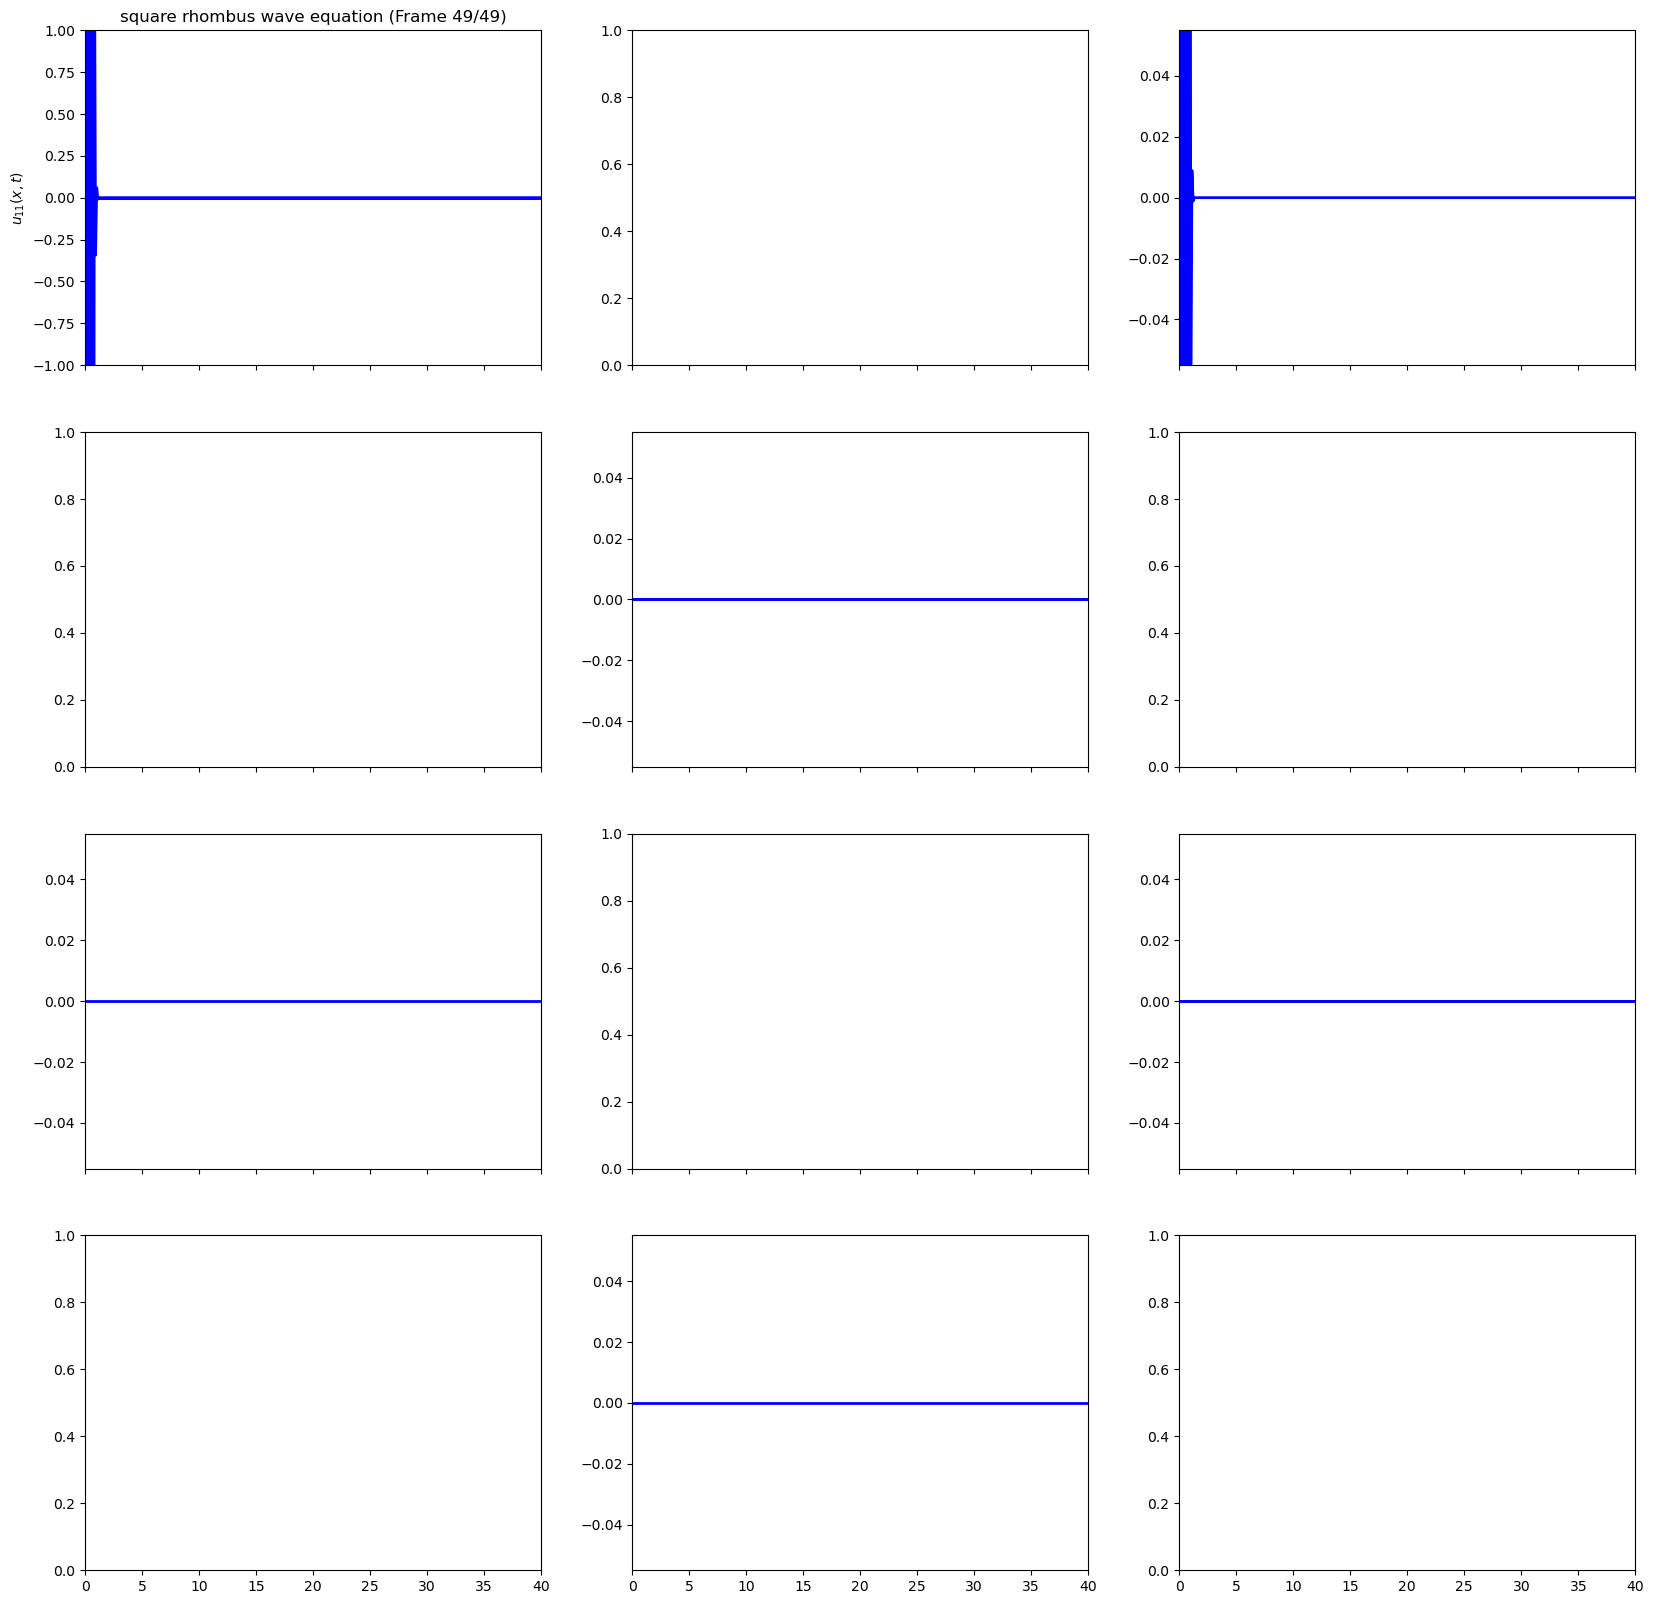

In [44]:
L = 40
N = 400
dx = L/N
x = np.linspace(0, L, N+1)

dt = 0.001
num_steps = 1000

m1 = 2.093e-3
m2 = 2.093e-3
I1 = 18.11e-9
I2 = 18.11e-9
k = 19235
k_theta = 0.0427
theta0 = np.pi / 180 * 25
l = 11.3e-3 / 2

K = k_theta / (k * l**2)
alpha = l / (np.sqrt(I1 / m1))
theta0 = np.pi / 180 * 25

def left_bc_atan_func(t, amp, freq):
    return amp * np.arctan(2.0 * np.pi * freq * t)
def left_bc_gaussian_func(t, amp, t0, sigma):
    return amp * np.exp( -((t - t0)**2) / (2*sigma**2) )

u11_init = np.zeros_like(x)
w11_init = np.zeros_like(x)
u21_init = np.zeros_like(x)
w21_init = np.zeros_like(x)
u12_init = np.zeros_like(x)
w12_init = np.zeros_like(x)
u22_init = np.zeros_like(x)
w22_init = np.zeros_like(x) 
v11_init = np.zeros_like(x) 
z11_init = np.zeros_like(x) 
v21_init = np.zeros_like(x)
z21_init = np.zeros_like(x)
v12_init = np.zeros_like(x)
z12_init = np.zeros_like(x)
v22_init = np.zeros_like(x)
z22_init = np.zeros_like(x)
theta11_init = np.zeros_like(x)
phi11_init = np.zeros_like(x)
theta21_init = np.zeros_like(x)
phi21_init = np.zeros_like(x)
theta12_init = np.zeros_like(x)
phi12_init = np.zeros_like(x)
theta22_init = np.zeros_like(x)
phi22_init = np.zeros_like(x)

state = (u11_init, w11_init, u21_init, w21_init, u12_init, w12_init, u22_init, w22_init, v11_init, z11_init, v21_init, z21_init, v12_init, z12_init, v22_init, z22_init, theta11_init, phi11_init, theta21_init, phi21_init, theta12_init, phi12_init, theta22_init, phi22_init)

snapshots_u11 = []
snapshots_u21 = []
snapshots_u12 = []
snapshots_u22 = []
snapshots_v11 = []
snapshots_v21 = []
snapshots_v12 = []
snapshots_v22 = []
snapshots_theta11 = []
snapshots_theta21 = []
snapshots_theta12 = []
snapshots_theta22 = []

store_interval = 20

current_time = 0.0

for step in range(num_steps):
    print(f"Step = {step} finished")

    u11, w11, u21, w21, u12, w12, u22, w22, v11, z11, v21, z21, v12, z12, v22, z22, theta11, phi11, theta21, phi21, theta12, phi12, theta22, phi22 = state
    u11[0] = left_bc_atan_func(t=current_time, amp = 0.004, freq = 0.1)
    w11[0] = left_bc_gaussian_func(t=current_time, amp = 0.0003, t0=3, sigma=5)
    theta11[0] = 0
    phi11[0] = 0
    state = (u11, w11, u21, w21, u12, w12, u22, w22, v11, z11, v21, z21, v12, z12, v22, z22, theta11, phi11, theta21, phi21, theta12, phi12, theta22, phi22)
    state = rk4_step(state, square_rhombus_coupled_wave_equations, current_time, dt, K, theta0, alpha, dx)

    current_time += dt

    if step % store_interval == 0:
        (u11_snap, w11_snap, u21_snap, w21_snap, u12_snap, w12_snap, u22_snap, w22_snap, v11_snap, z11_snap, v21_snap, z21_snap, v12_snap, z12_snap, v22_snap, z22_snap, theta11_snap, phi11_snap, theta21_snap, phi21_snap, theta12_snap, phi12_snap, theta22_snap, phi22_snap) = state
        snapshots_u11.append(u11_snap.copy())
        snapshots_u21.append(u21_snap.copy())
        snapshots_u12.append(u12_snap.copy())
        snapshots_u22.append(u22_snap.copy())
        snapshots_v11.append(v11_snap.copy())
        snapshots_v21.append(v21_snap.copy())
        snapshots_v12.append(v12_snap.copy())
        snapshots_v22.append(v22_snap.copy())
        snapshots_theta11.append(theta11_snap.copy())
        snapshots_theta21.append(theta21_snap.copy())
        snapshots_theta12.append(theta12_snap.copy())
        snapshots_theta22.append(theta22_snap.copy())
        
fig, axes = plt.subplots(4, 3, figsize=(20, 20), sharex=True)

# 将二维数组展开为一维数组
axes = axes.ravel()

# 解包展开后的 axes
axu11, axu21, axu12, axu22, axv11, axv21, axv12, axv22, axtheta11, axtheta21, axtheta12, axtheta22 = axes

lineu11, = axu11.plot([], [], 'b-', lw=2, label="u11")
lineu21, = axu11.plot([], [], 'b-', lw=2, label="u21")
lineu12, = axu12.plot([], [], 'b-', lw=2, label="u12")
lineu22, = axu11.plot([], [], 'b-', lw=2, label="u22")
linev11, = axv11.plot([], [], 'b-', lw=2, label="v11")
linev21, = axv11.plot([], [], 'b-', lw=2, label="v21")
linev12, = axv12.plot([], [], 'b-', lw=2, label="v12")
linev22, = axv11.plot([], [], 'b-', lw=2, label="v22")
linetheta11, = axtheta11.plot([], [], 'b-', lw=2, label="theta11")
linetheta21, = axtheta11.plot([], [], 'b-', lw=2, label="theta21")
linetheta12, = axtheta12.plot([], [], 'b-', lw=2, label="theta12")
linetheta22, = axtheta11.plot([], [], 'b-', lw=2, label="theta22")

axu11.set_xlim(0, L)
axu11.set_ylim(-1, 1)
axu11.set_ylabel(r"$u_{11}(x, t)$")
axu11.set_title("square rhombus wave equation")

def init():
    lineu11.set_data([], [])
    lineu21.set_data([], [])
    lineu12.set_data([], [])
    lineu22.set_data([], [])
    linev11.set_data([], [])
    linev21.set_data([], [])
    linev12.set_data([], [])
    linev22.set_data([], [])
    linetheta11.set_data([], [])
    linetheta21.set_data([], [])
    linetheta12.set_data([], [])
    linetheta22.set_data([], [])
    return (lineu11, lineu21, lineu12, lineu22, linev11, linev21, linev12, linev22, linetheta11, linetheta21, linetheta12, linetheta22)

def animate(frame_idx):
    lineu11.set_data(x, snapshots_u11[frame_idx])
    lineu21.set_data(x, snapshots_u21[frame_idx])
    lineu12.set_data(x, snapshots_u12[frame_idx])
    lineu22.set_data(x, snapshots_u22[frame_idx])
    linev11.set_data(x, snapshots_v11[frame_idx])
    linev21.set_data(x, snapshots_v21[frame_idx])
    linev12.set_data(x, snapshots_v12[frame_idx])
    linev22.set_data(x, snapshots_v22[frame_idx])
    linetheta11.set_data(x, snapshots_theta11[frame_idx])
    linetheta21.set_data(x, snapshots_theta21[frame_idx])
    linetheta12.set_data(x, snapshots_theta12[frame_idx])
    linetheta22.set_data(x, snapshots_theta22[frame_idx])
    axu11.set_title(f"square rhombus wave equation (Frame {frame_idx}/{len(snapshots_u11)-1})")
    return (lineu11, lineu21, lineu12, lineu22, linev11, linev21, linev12, linev22, linetheta11, linetheta21, linetheta12, linetheta22)

ani = animation.FuncAnimation(
    fig, animate, init_func=init, frames=len(snapshots_u11), interval=50, blit=True
)

ani.save("square_rhombus_block_wave.gif", writer='pillow', fps=20)

plt.show()